In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

import math
from numpy.random import randn
from scipy.integrate import solve_ivp
from math import atan2
from tqdm import tqdm

from PyQt5 import QtCore
from PyQt5.QtWidgets import QWidget

from datetime import datetime, timedelta
import sys
import matplotlib.pyplot as plt



G = 6.67430e-11                             # Gravitational constant (m^3 kg^-1 s^-2)
M_EARTH = 5.972e24                          # Mass of Earth (kg)
EARTH_SEMIMAJOR = 6378137.0                 # Radius of Earth (m)
EARTH_SEMIMINOR = 6356752.314245            # Semi-minor axis of Earth (m)
FLATTENING = 1/298.257223563                # Flattening of Earth (dimensionless)
E_SQUARED = FLATTENING * (2 - FLATTENING)   # Eccentricity squared (dimensionless)
ATMOSPHERE_HEIGHT = 120e3                   # Approximate height of the atmosphere (m)
CD = 2.2                                    # Drag coefficient (dimensionless)
A = 1.0                                     # Cross-sectional area of the satellite (m^2)
M_SAT = 500                                 # Mass of the satellite (kg)
RHO_0 = 1.225                               # Air density at sea level (kg/m^3)
H_SCALE = 8500                              # Scale height of the atmosphere (m)

In [2]:
def curvature_in_prime_vertical(phi):
            return EARTH_SEMIMAJOR / np.sqrt(1 - E_SQUARED * np.sin(phi)**2)
        
def latitude_iterator_and_height(x, y, z):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan(z / (r * (1 - E_SQUARED)))
    phi_new = phi + 100
    
    while np.abs(phi_new - phi) > 1e-9:
        phi = phi_new
        N = curvature_in_prime_vertical(phi)
        phi_new = np.arctan2(z + (N * E_SQUARED) * np.sin(phi), r - (N * E_SQUARED) * np.cos(phi))
    
    height = (r / np.cos(phi)) - N
    if height < 0:
        height = 0
            
    return phi_new, height


def earth_radius_WGS84(latitude):
    numerator = (EARTH_SEMIMAJOR**2 * np.cos(latitude))**2 + (EARTH_SEMIMINOR**2 * np.sin(latitude))**2
    denominator = (EARTH_SEMIMAJOR * np.cos(latitude))**2 + (EARTH_SEMIMINOR * np.sin(latitude))**2
    return np.sqrt(numerator / denominator)

def lat_long_height(x, y, z):
    r = np.linalg.norm([x,y,z])
    longitude = np.arctan2(y, x)
    latitude, height = latitude_iterator_and_height(x, y, z)
    R_earth = earth_radius_WGS84(latitude)
    height = r - R_earth
    return latitude, longitude, height

def latitude_iterator_and_height_plot(x, y, z):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)

    r = np.sqrt(x**2 + y**2)
    phi = np.arctan(z / (r * (1 - E_SQUARED)))
    phi_new = phi + 100  # ensures entry into the loop

    converged = np.zeros_like(phi, dtype=bool)
    max_iter = 100
    iter_count = 0

    while not np.all(converged) and iter_count < max_iter:
        phi[~converged] = phi_new[~converged]
        N = curvature_in_prime_vertical(phi)
        phi_new[~converged] = np.arctan2(z[~converged] + (N[~converged] * E_SQUARED) * np.sin(phi[~converged]),
                                         r[~converged] - (N[~converged] * E_SQUARED) * np.cos(phi[~converged]))
        converged[~converged] = np.abs(phi_new[~converged] - phi[~converged]) <= 1e-9
        iter_count += 1

    phi_final = phi_new
    N_final = curvature_in_prime_vertical(phi_final)
    height = (r / np.cos(phi_final)) - N_final
    height = np.maximum(height, 0)  # ensure non-negative height

    return phi_final, height

def lat_long_height_plot(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    longitude = np.arctan2(z, np.sqrt(x**2 + y**2))
    latitude, height = latitude_iterator_and_height_plot(x, y, z)
    R_earth = earth_radius_WGS84(latitude)
    height = r - R_earth
    return latitude, longitude, height

def atmospheric_density(altitude):
    # White noise as random perturbations of magnitude 0.1*RHO_0
    density = RHO_0 * np.exp(-altitude / H_SCALE)
    return density

            
def ode(t, state_x):
        x, y, z, vx, vy, vz= state_x        
        
        r = np.linalg.norm(state_x[:3])

        altitude = lat_long_height(x, y, z)[2]

        # Gravity
        F_gravity = -G * M_EARTH / r**2

        # Drag
        rho = atmospheric_density(altitude)
        
        v = np.linalg.norm([vx,vy,vz])

        F_drag_x = -0.5 * rho * CD * A * v * vx / M_SAT
        F_drag_y = -0.5 * rho * CD * A * v * vy / M_SAT
        F_drag_z = -0.5 * rho * CD * A * v * vz / M_SAT
        # print("drag:", [F_drag_x, F_drag_y, F_drag_z])
        
        # Acceleration
        ax = F_gravity * (x / r) + F_drag_x
        ay = F_gravity * (y / r) + F_drag_y
        az = F_gravity * (z / r) + F_drag_z

        return np.array([vx, vy, vz, ax, ay, az])

### you can use this to simulate the true trajectory, add some noise to be the measurements, and use it in the UKF as the process model
def f(state_x, dt):

    """state vector = state_x = [x,y,z,vx, vy, vz]"""
    solution = solve_ivp(ode, t_span=[0, dt], y0=state_x, method='RK45', t_eval=[dt], max_step=dt)
    # print(solution.y)
    return solution.y.flatten()

state = [EARTH_SEMIMAJOR+180e3, 0, 0, 
         0, 7800, 0]
# state = [EARTH_SEMIMAJOR+180e3, 0, 0, 
#          0, 7800/ np.sqrt(2), 7800/ np.sqrt(2)]
# state = [EARTH_SEMIMAJOR+300e3, 0, 0, 
#          0, 7600, 1000]
state_arr = []
altitude_arr = []
for i in tqdm(range(5000)):
    # print(state)
    # print(f(state, 10))
    state = f(state, dt=50)
    
    state_arr.append(state)
    altitude = lat_long_height(state[0], state[1], state[2])[2]
    altitude_arr.append(altitude)
    if altitude < 0: break

state_arr = np.array(state_arr)
altitude_arr = np.array(altitude_arr)

def satellite_UKF(fx, hx, dt=1.0):
    ### UKF
    sigmas_generator = MerweScaledSigmaPoints(n=6, alpha=0.1, beta = 2., kappa= -3.)  #kappa = -3.
    ukf = UKF(dim_x=6, dim_z=3, fx = fx, hx = hx, dt = 50, points=sigmas_generator) # take f, h from Jai and Vijay
    # print(ukf.Q)


    """ ============== Define items in UKF ============================"""

    def ukf_Q(dt, dim, var_):
        process_noise = np.zeros((dim, dim))
        process_noise[np.ix_([0,3], [0,3])] = Q_discrete_white_noise(dim=2, dt=dt, var=var_)  # Q matrix for x and vx
        process_noise[np.ix_([1,4], [1,4])] = Q_discrete_white_noise(dim=2, dt=dt, var=var_)  # Q matrix for y and vy
        process_noise[np.ix_([2,5], [2,5])] = Q_discrete_white_noise(dim=2, dt=dt, var=var_)  # Q matrix for z and vz
        return process_noise

    ### initial state values of (x,y,z,vx,vy,vz)
    ukf.x = np.array(state)  # initial state
    ukf.P = np.diag([50**2, 50**2, 50**2,
                        5**2, 5**2, 5**2])    # experiment this
    ### uncertainty in the process model
    ukf.Q = ukf_Q(dt=50, dim=6, var_=1)


    """### radar measurement noise (for the simple UKF only! change this!!!!!!!!!!!!!!!!!!!!!!)"""
    x_std = 500  # meters. 
    y_std = 500  # meters.
    z_std = 10  # meters. 
    ukf.R = np.diag([x_std**2, y_std**2, z_std**2])

  0%|          | 0/5000 [00:00<?, ?it/s]

 41%|████      | 2030/5000 [00:05<00:07, 384.80it/s]


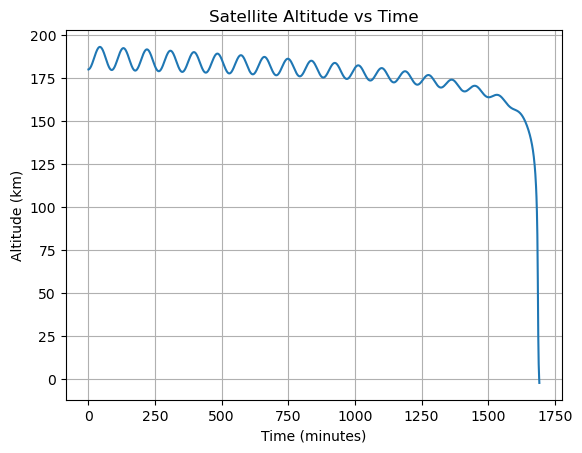

In [3]:
time = np.arange(len(altitude_arr)) * 50  # time in seconds

plt.figure()
plt.plot(time / 60, altitude_arr / 1000)
plt.xlabel('Time (minutes)')
plt.ylabel('Altitude (km)')
plt.title('Satellite Altitude vs Time')
plt.grid(True)
plt.show()

In [8]:
def hx(state):
    return state[:3]

def simulate_radar_measurement(true_state, missing_rate=0.2):
    if np.random.rand() < missing_rate:
        return np.array([0, 0, 0])  # Simulate a missing measurement
    x_meas = true_state[0] + np.random.normal(0, 500)
    y_meas = true_state[1] + np.random.normal(0, 500)
    z_meas = true_state[2] + np.random.normal(0, 10)
    return np.array([x_meas, y_meas, z_meas])

In [16]:
# =================== UKF ===================
def satellite_UKF(fx, hx, dt=50.0):
    points = MerweScaledSigmaPoints(n=6, alpha=0.1, beta=2., kappa=-3.)
    ukf = UKF(dim_x=6, dim_z=3, fx=fx, hx=hx, dt=dt, points=points)
    
    ukf.x = state_arr[0].copy()
    ukf.P = np.diag([50**2, 50**2, 50**2, 5**2, 5**2, 5**2])
    
    def ukf_Q(dt, dim, var_):
        Q = np.zeros((dim, dim))
        Q[np.ix_([0,3], [0,3])] = Q_discrete_white_noise(2, dt=dt, var=var_)
        Q[np.ix_([1,4], [1,4])] = Q_discrete_white_noise(2, dt=dt, var=var_)
        Q[np.ix_([2,5], [2,5])] = Q_discrete_white_noise(2, dt=dt, var=var_)
        return Q

    ukf.Q = ukf_Q(dt, dim=6, var_=1)
    ukf.R = np.diag([500**2, 500**2, 10**2])
    return ukf

ukf = satellite_UKF(fx=lambda x, dt: f(x, dt), hx=hx)

# =================== UKF estimation loop ===================
estimated_states = []
zs = []
true_pos = []

for i in range(len(state_arr)):
    true_state = state_arr[i]
    z = simulate_radar_measurement(state_arr[i])
    ukf.predict()

    if not np.all(z == 0):
        ukf.update(z)
    
    zs.append(z)
    true_pos.append(true_state[:3])
    estimated_states.append(ukf.x.copy())

estimated_states = np.array(estimated_states)

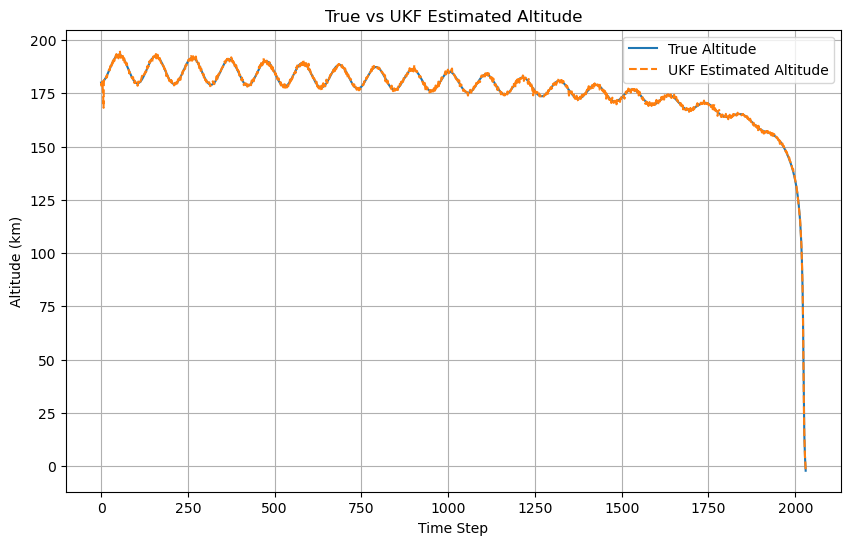

In [10]:
# =================== Plotting ===================
# Altitude comparison
true_altitudes = altitude_arr / 1000
estimated_altitudes = (np.linalg.norm(estimated_states[:, :3], axis=1) - EARTH_SEMIMAJOR) / 1000

plt.figure(figsize=(10, 6))
plt.plot(true_altitudes, label='True Altitude')
plt.plot(estimated_altitudes, label='UKF Estimated Altitude', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Altitude (km)')
plt.title('True vs UKF Estimated Altitude')
plt.legend()
plt.grid(True)
plt.show()

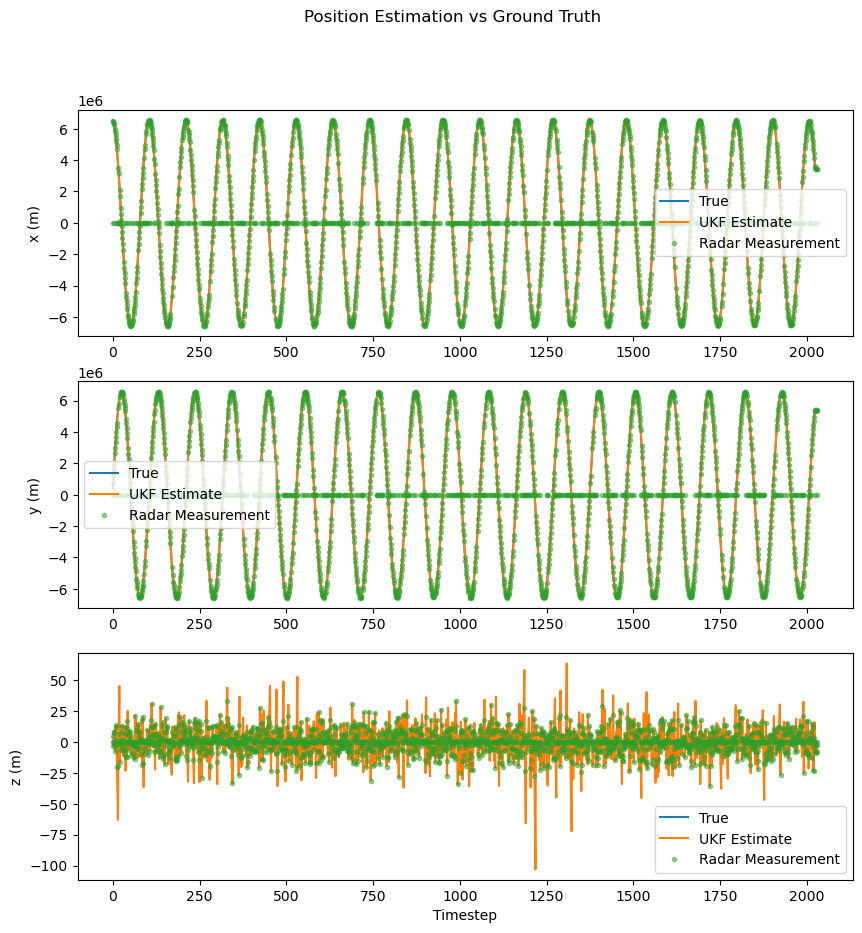

In [15]:
true_pos = state_arr[:, :3]
estimated_pos = estimated_states[:, :3]
measurements = np.array(zs)  

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
labels = ['x', 'y', 'z']
for i in range(3):
    axs[i].plot(true_pos[:, i], label='True')
    axs[i].plot(estimated_pos[:, i], label='UKF Estimate')
    axs[i].plot(measurements[:, i], '.', label='Radar Measurement', alpha=0.5)
    axs[i].set_ylabel(labels[i] + ' (m)')
    axs[i].legend()
plt.xlabel('Timestep')
plt.suptitle('Position Estimation vs Ground Truth')
plt.show()

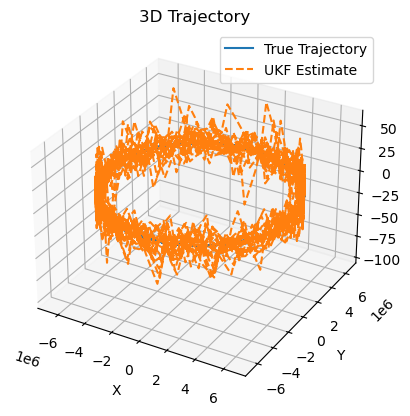

In [18]:
true_pos = np.array(true_pos)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(true_pos[:,0], true_pos[:,1], true_pos[:,2], label='True Trajectory')
ax.plot(estimated_pos[:,0], estimated_pos[:,1], estimated_pos[:,2], label='UKF Estimate', linestyle='--')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory')
ax.legend()
plt.show()

RMSE (x, y, z): [ 963.99287273 8643.72323496   13.27991365]


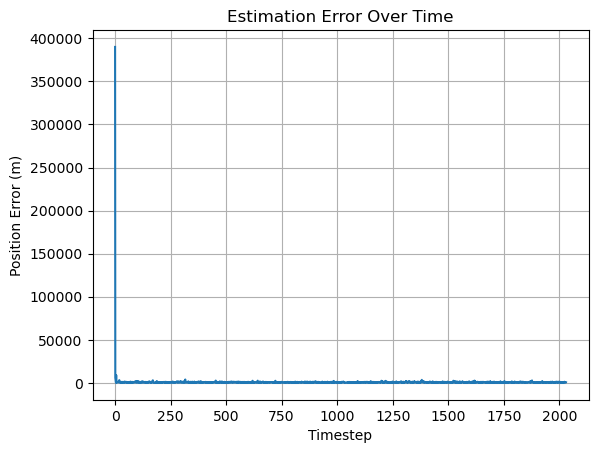

In [19]:
error = estimated_pos - true_pos
rmse = np.sqrt(np.mean(error**2, axis=0))
print("RMSE (x, y, z):", rmse)

plt.figure()
plt.plot(np.linalg.norm(error, axis=1))
plt.xlabel("Timestep")
plt.ylabel("Position Error (m)")
plt.title("Estimation Error Over Time")
plt.grid()
plt.show()

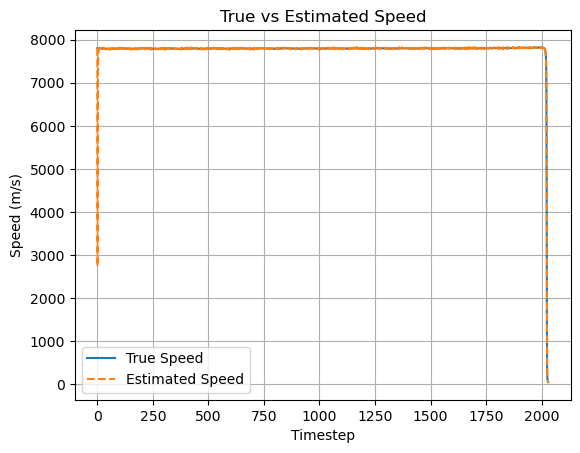

In [20]:
true_vel = state_arr[:, 3:6]
estimated_vel = estimated_states[:, 3:6]

plt.figure()
plt.plot(np.linalg.norm(true_vel, axis=1), label='True Speed')
plt.plot(np.linalg.norm(estimated_vel, axis=1), label='Estimated Speed', linestyle='--')
plt.xlabel("Timestep")
plt.ylabel("Speed (m/s)")
plt.title("True vs Estimated Speed")
plt.legend()
plt.grid()
plt.show()

In [7]:
# def ukf_Q(dim, dt, var_):
#     Q = np.zeros((dim, dim))
#     Q[np.ix_([0, 3], [0, 3])] = Q_discrete_white_noise(dim=2, dt=dt,var=var_)  # Q matrix for how other noise affect x and vx
#     Q[np.ix_([1, 4], [1, 4])] = Q_discrete_white_noise(dim=2, dt=dt,var=var_)  # Q matrix for how other noise affect y and vy
#     Q[np.ix_([2, 5], [2, 5])] = Q_discrete_white_noise(dim=2, dt=dt,var=var_)  # Q matrix for how other noise affect z and vz
#     return Q

# class Predictor(QWidget):
#     def __init__(self, state0, dt=1.0):
#         super().__init__()

#         """state0 :list. e.g. state0=[EARTH_SEMIMAJOR + 400e3, 1, -1, 1, 7700, 1] 
#             """

#         """ =============== Generate sigma points """
#         ### initialise self.ukf
#         sigmas_generator = MerweScaledSigmaPoints(n=6, alpha=0.1, beta=2., kappa=-3.)  # kappa = -3.
#         self.ukf = UKF(dim_x=6, dim_z=3, fx=f, hx=h_radar, dt=dt, points=sigmas_generator)  # take f, h from Jai and Vijay
#         # print(self.ukf.Q)

#         """ ============== Define items in self.ukf """
#         ### initial state values of (x,y,z,vx,vy,vz)
#         self.ukf.x = np.array(state0)  # initial state
#         ### initial uncertainty of the state
#         self.ukf.P = np.diag([50 ** 2, 50 ** 2, 50 ** 2,
#                          5 ** 2, 5 ** 2, 5 ** 2])  # experiment this
#         ### uncertainty in the process model
#         self.ukf.Q = ukf_Q(6, dt=dt, var_=0.01)
#         # self.ukf.Q = np.zeros((6, 6))
#         # self.ukf.Q[np.ix_([0, 3], [0, 3])] = Q_discrete_white_noise(dim=2, dt=dt,
#         #                                                        var=0.01)  # Q matrix for how other noise affect x and vx
#         # self.ukf.Q[np.ix_([1, 4], [1, 4])] = Q_discrete_white_noise(dim=2, dt=dt,
#         #                                                        var=0.01)  # Q matrix for how other noise affect y and vy
#         # self.ukf.Q[np.ix_([2, 5], [2, 5])] = Q_discrete_white_noise(dim=2, dt=dt,
#         #                                                        var=0.01)  # Q matrix for how other noise affect z and vz

#         # range_std = 10 # meters. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
#         # elev_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
#         # azim_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!1 (get from radar)
#         # self.ukf.R = np.diag([range_std**2, elev_std**2, azim_std**2])

#         """### radar measurement noise (for the simple self.ukf only! change this!!!!!!!!!!!!!!!!!!!!!!)"""
#         x_std = 500  # meters.
#         y_std = 500  # meters.
#         z_std = 10  # meters.
#         self.ukf.R = np.diag([x_std**2, y_std**2, z_std**2])

#         # range_std = 10  # meters.
#         # azim_std = 0.002  # radians. (theta)
#         # elev_std = 0.002  # radians. (phi)
#         # self.ukf.R = np.diag([range_std ** 2, azim_std ** 2, elev_std ** 2])

#         self.xs_prior = []
#         self.zs = []
#         self.xs = []
#         self.Ps = []
#         self.ts = [0.0]


#     @QtCore.pyqtSlot(dict, tuple)
#     def predictor_loop(self, info, update):

#         # print(f"{info['name']} observed: {update}")

#         ## PROBABLY TEMPORARY DT
#         dt = 50.
#         # print(info['obs-time'])
#         self.ts.append(info['obs-time'])

#         stime, radobj = info['stime'], info['radobj']

#         self.ukf.Q = ukf_Q(dim=6, dt=dt, var_=0.01)
#         self.ukf.predict(dt=dt)
#         # # self.ukf.hx = lambda x: do_conversions(x[:3], stime, radobj)
#         self.xs_prior.append(self.ukf.x_prior)
#         if update != (0, 0, 0):
#             self.ukf.update(list(update))
#         x_post = self.ukf.x
#         self.xs.append(x_post)
#         print(f'x_post is: {x_post}')
#         # x_cov = self.ukf.P
#         # self.Ps.append(x_cov)

#         # """Predict landing ====================================================================="""
#         altitude_val = lat_long_height(x_post[0], x_post[1], x_post[2])[2]

#         print("radar height: ", np.abs(np.linalg.norm(list(update)))-EARTH_SEMIMAJOR)
#         print("altitude=", altitude_val, "\n")
#         #
#         # if altitude_val < 0:
#         #     sys.exit()
#         #
#         #
#         # if altitude_val <= 200e3:
#         #     # print("============== predict landing ================")
#         #     ### sample from the updated state distribution and predict landing position
#         #     state_samples = np.random.multivariate_normal(mean=x_post, cov=x_cov, size=5)
#         #
#         #     ### record the landing position (inertia coord), and landing time
#         #     predicted_landing_ECI = []
#         #     predicted_landing_latlon = []
#         #     predicted_landing_time = []
#         #
#         #     for state0 in state_samples:
#         #         # t_eval_arr = np.linspace(ts[-1], ts[-1]+100000, 1000)
#         #         stop_condition.terminal = True
#         #         stop_condition.direction = -1
#         #         start = self.ts[-1]
#         #         end = start + 1000000
#         #         landing = solve_ivp(fun=ode, t_span=[start, end], y0=state0, method='RK45', t_eval=[end],
#         #                             events=stop_condition)
#         #         while (landing.success and len(landing.y) > 0):
#         #             end += 1000000
#         #             landing = solve_ivp(fun=ode, t_span=[start, end], y0=state0, method='RK45', t_eval=[end],
#         #                                 events=stop_condition)
#         #         if landing.success and len(landing.y) == 0:
#         #             # print(landing.y_events, np.linalg.norm(landing.y_events[0][0][:3])-R_EARTH)
#         #             # print(landing.y_events[0][0][:3])
#         #             landing_time = landing.t_events[0][0]
#         #             landing_position = landing.y_events[0][0][:3]
#         #             landing_position_latlon = lat_long_height(landing_position[0], landing_position[1],
#         #                                                       landing_position[2])
#         #             predicted_landing_ECI.append(landing_position)
#         #             predicted_landing_latlon.append(landing_position_latlon)
#         #             predicted_landing_time.append(landing_time)

#             # print(f"We are getting out: {x_post}")
#             # print(self.ts, self.xs)